# Bounding configuration GP example

This notebook is designed to test whether a simple simple comprised of bounding boxes can be generated using [deap](http://deap.readthedocs.io/en/master/api/tools.html), a Python Evolutionary Algorithm Package.

In [1]:
import numpy as np
import pydot
from airconics.topology import Topology

from IPython.display import Image, display

In [2]:
config = Topology()
# Try to compile a single individual and visualise both the tree and geometry
config.randomize()

print(config)

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config.Display(renderer)

renderer

OrderedDict([('fuselage1_0', 1)])
2
OrderedDict([('fuselage1_0', 1)])
OrderedDict([('fuselage1_0', 0), ('liftingsurface1_3', 1)])
1
fuselage1(rand(), rand(), rand(), rand(), rand(), rand(), rand(), mirror2(fuselage0(rand(), rand(), rand(), rand(), rand(), rand(), rand()), liftingsurface1(rand(), rand(), rand(), rand(), rand(), rand(), random_lsurfdict(), mirror1(empty))))


<TornadoWebRenderer at http://pauls-macbook-air.local:55952/get/4ef1e2e3d8274f3586cbbe1d478c7a6b>

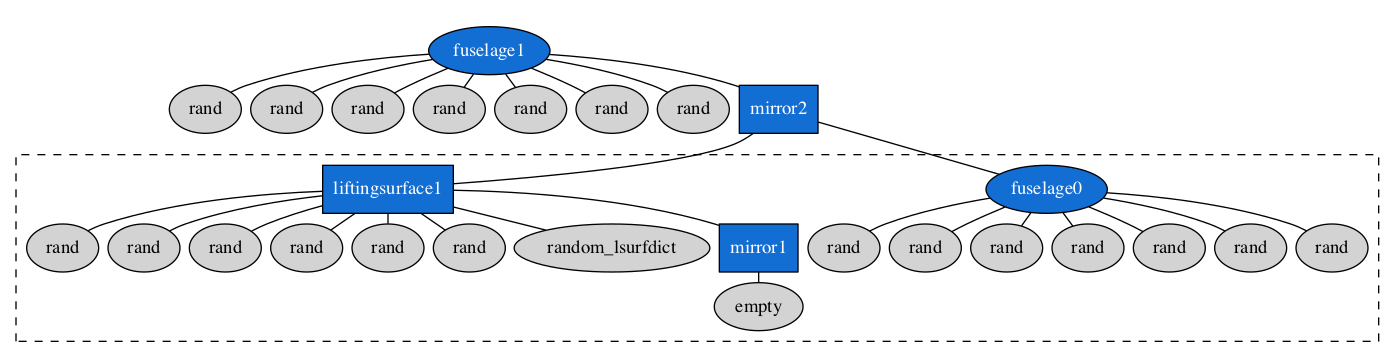

In [3]:
Image(config.pydot_graph().create_png())

In [4]:
config2 = Topology()

expr_string = """fuselage1(0., 0., 0., 1.0, 0.182, 0.293, 0.5, mirror2(
    liftingsurface0(0., 0., 0., 1., 0.68, 0., AirlinerTP),
    liftingsurface0(0.55, 0., 0., 1., 0.5, 0.28, AirlinerFin)))"""
config2.from_string(expr_string)

print(config2)

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config2.Display(renderer)

renderer



OrderedDict([('fuselage1_0', 1)])
2
OrderedDict([('fuselage1_0', 1)])
OrderedDict([('fuselage1_0', 0)])
fuselage1(0.0, 0.0, 0.0, 1.0, 0.182, 0.293, 0.5, mirror2(liftingsurface0(0.0, 0.0, 0.0, 1.0, 0.68, 0.0, AirlinerTP), liftingsurface0(0.55, 0.0, 0.0, 1.0, 0.5, 0.28, AirlinerFin)))


<TornadoWebRenderer at http://pauls-macbook-air.local:55955/get/66901c5e80c648b8ac8f4bf85a84367a>

In [5]:
# config2.Write('GP_output.step')
graph = config2.pydot_graph()
Image(graph.create_png())

repr(config2._deap_tree)

'[<deap.gp.Primitive object at 0x119b528e8>, <deap.gp.Terminal object at 0x119b660f0>, <deap.gp.Terminal object at 0x119b66140>, <deap.gp.Terminal object at 0x119b66190>, <deap.gp.Terminal object at 0x119b661e0>, <deap.gp.Terminal object at 0x119b66230>, <deap.gp.Terminal object at 0x119b66280>, <deap.gp.Terminal object at 0x119b662d0>, <deap.gp.Primitive object at 0x119b52a48>, <deap.gp.Primitive object at 0x119555d60>, <deap.gp.Terminal object at 0x119b66320>, <deap.gp.Terminal object at 0x119b66370>, <deap.gp.Terminal object at 0x119b663c0>, <deap.gp.Terminal object at 0x119b66410>, <deap.gp.Terminal object at 0x119b66460>, <deap.gp.Terminal object at 0x119b664b0>, <deap.gp.Terminal object at 0x119676f00>, <deap.gp.Primitive object at 0x119555d60>, <deap.gp.Terminal object at 0x119b66500>, <deap.gp.Terminal object at 0x119b66550>, <deap.gp.Terminal object at 0x119b665a0>, <deap.gp.Terminal object at 0x119b665f0>, <deap.gp.Terminal object at 0x119b66640>, <deap.gp.Terminal object at 

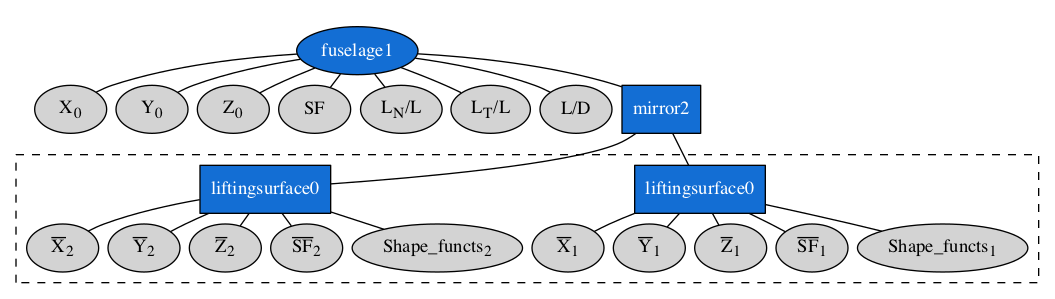

In [6]:
# For now, I'll have to do this by hand...
graph = """digraph G {
ranksep="0.1";
nodesep="0.1";
# splines=ortho;
node [style=filled];
edge [arrowhead=none];
subgraph cluster_standard {
color=invis;
0 [shape=ellipse, fillcolor="#136ed4", label=fuselage1, fontcolor="white"];
1 [shape=ellipse, label=<X<SUB>0</SUB>>];
2 [shape=ellipse, label=<Y<SUB>0</SUB>>];
3 [shape=ellipse, label=<Z<SUB>0</SUB>>];
4 [shape=ellipse, label=<SF>];
5 [shape=ellipse, label=<L<SUB>N</SUB>/L>];
6 [shape=ellipse, label=<L<SUB>T</SUB>/L>];
7 [shape=ellipse, label="L/D"];
8 [shape=box, fillcolor="#136ed4", label="mirror2", fontcolor="white"];
}

subgraph cluster_mirrored {
style=dashed;
9 [shape=box, fillcolor="#136ed4", label=liftingsurface0, fontcolor="white"];
10 [shape=ellipse, label=<<O>X</O><SUB>1</SUB>>];
11 [shape=ellipse, label=<<O>Y</O><SUB>1</SUB>>];
12 [shape=ellipse, label=<<O>Z</O><SUB>1</SUB>>];
13 [shape=ellipse, label=<<O>SF</O><SUB>1</SUB>>];
20 [shape=ellipse, label=<Shape_functs<SUB>1</SUB>>];

rank=same;
14 [shape=box, fillcolor="#136ed4", label=liftingsurface0, fontcolor="white"];
15 [shape=ellipse, label=<<O>X</O><SUB>2</SUB>>];
16 [shape=ellipse, label=<<O>Y</O><SUB>2</SUB>>];
17 [shape=ellipse, label=<<O>Z</O><SUB>2</SUB>>];
18 [shape=ellipse, label=<<O>SF</O><SUB>2</SUB>>];
21 [shape=ellipse, label=<Shape_functs<SUB>2</SUB>>];
}

0 -> 8;
8-> 9;
8 -> 14;

0 -> 1;
0 -> 2;
0 -> 3;
0 -> 4;
0 -> 5;
0 -> 6;
0 -> 7;
# 0 -> 9;
# 0 -> 14;
9 -> 10;
9 -> 11;
9 -> 12;
9 -> 13;
9-> 20;
14 -> 15;
14 -> 16;
14 -> 17;
14 -> 18;
14->21;
}
"""
dotgraph = pydot.graph_from_dot_data(graph)
# dotgraph.write_svg('/home/pchambers/Documents/PhD/SABTalk_2017/images/tree1.svg')
Image(dotgraph.create_png())

In [7]:
# dotgraph.write_pdf('/home/pchambers/Documents/PhD/Aviation2017/aviation_2017_paper/figure/gplayout_tree2.pdf')

## Conventional Airliner

OrderedDict([('fuselage2_0', 2)])
OrderedDict([('fuselage2_0', 1)])
2
OrderedDict([('fuselage2_0', 1)])
OrderedDict([('fuselage2_0', 0)])


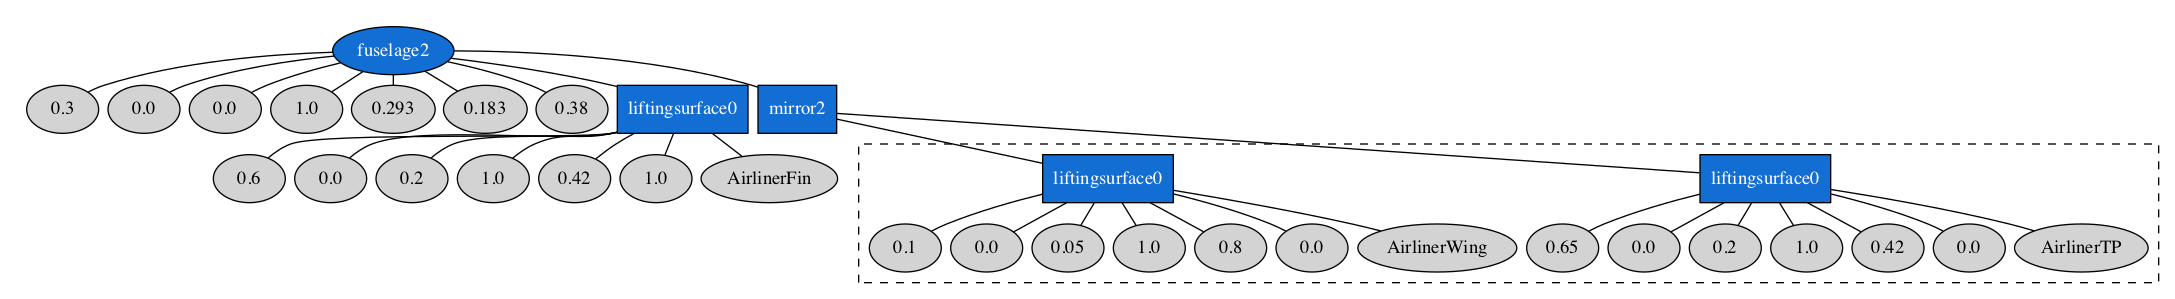

<TornadoWebRenderer at http://pauls-macbook-air.local:55958/get/16dd1dbb01e34da7890452c3c335e819>

In [8]:
# The string method didn't work: let's do it manually:
topo = Topology()

expr_string = """fuselage2(0.3, 0., 0., 1., 0.293, 0.183, 0.38, 
            liftingsurface0(0.6, 0., 0.2, 1., 0.42, 1.0, AirlinerFin) mirror2(
                liftingsurface0(0.65, 0., 0.2, 1., 0.42, 0., AirlinerTP), liftingsurface0( 0.1, 0., 0.05, 1., 0.8, 0., AirlinerWing)))"""

topo.from_string(expr_string)

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer

## General Atomics MQ-1 Predator

OrderedDict([('fuselage2_0', 2)])
OrderedDict([('fuselage2_0', 1)])
2
OrderedDict([('fuselage2_0', 1)])
OrderedDict([('fuselage2_0', 0)])


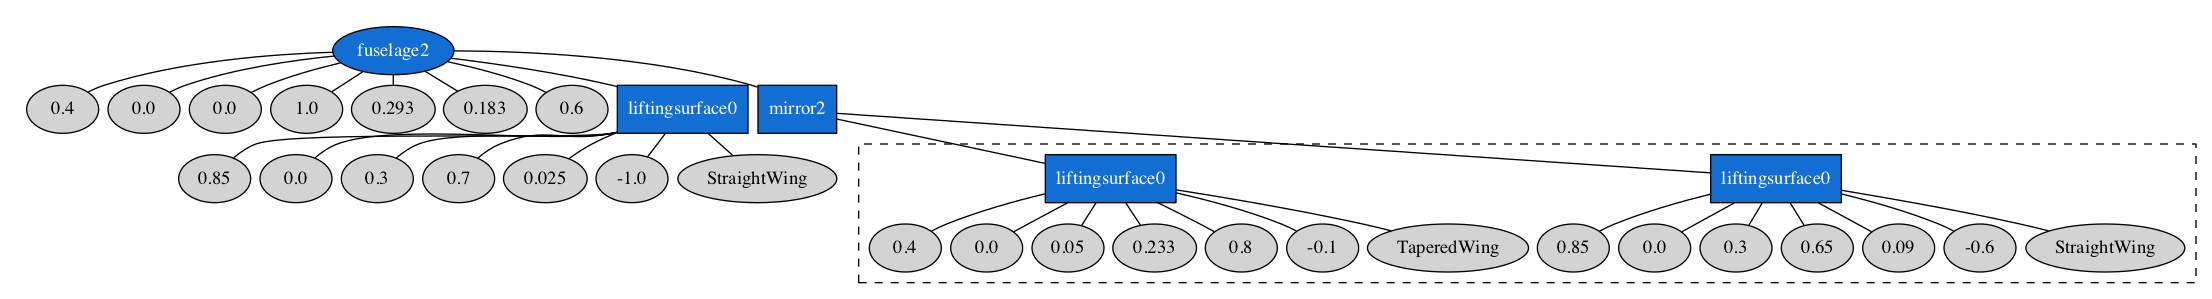

<TornadoWebRenderer at http://pauls-macbook-air.local:56199/get/f1e437f4e2af476dac47f1570f546856>

In [30]:
# The string method didn't work: let's do it manually:
topo = Topology(MaxAttachments=4)

expr_string = """fuselage2(0.4, 0., 0., 1., 0.293, 0.183, 0.6, 
            liftingsurface0(0.85, 0., 0.3, 0.7, 0.025, -1.0, StraightWing) mirror2(
                liftingsurface0(0.85, 0., 0.3, 0.65, 0.09, -0.6, StraightWing), liftingsurface0(0.4, 0., 0.05, 0.233, 0.8, -0.1, TaperedWing)))"""

topo.from_string(expr_string)

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer